## Imports & Loading Data

In [2]:
import os
import glob
import numpy as np
import pandas as pd

from pprint import pprint

import tensorflow as tf

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import Model, layers, Sequential, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau


import matplotlib.pyplot as plt

In [3]:
local_weights_file = './inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

train_path = "./plant/train"
valid_path = "./plant/valid"
test_path = "./test"

In [4]:
training_images = []

for root, dirs, files in os.walk(train_path):
    for file in files:
        training_images.append(os.path.join(root, file))
                               
validation_images = []

for root, dirs, files in os.walk(valid_path):
    for file in files:
        validation_images.append(os.path.join(root, file))

In [5]:
print("Training Path:" + train_path)
print("Training Classes:" + str(len(os.listdir(train_path))))
print("Training Images:" + str(len(training_images)))

print("\n")

print("Validation:")
print("Validation Path:" + valid_path)
print("Validation Classes:" + str(len(os.listdir(valid_path))))
print("Validation Images:" + str(len(validation_images)))

print("\n")

print("Testing:")
print("Testing Path:" + test_path)
print("Testing Images:" + str(len(os.listdir(os.path.join(test_path, 'test')))))

Training Path:./plant/train
Training Classes:41
Training Images:75746


Validation:
Validation Path:./plant/valid
Validation Classes:41
Validation Images:18772


Testing:
Testing Path:./test
Testing Images:33


In [6]:
train_datagen = ImageDataGenerator(
    rescale=1/255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1/255)

test_datagen = ImageDataGenerator(rescale=1/255)

In [7]:
batch_size = 32

In [8]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    batch_size = batch_size,
    class_mode = 'categorical',
    target_size = (150, 150),
    color_mode="rgb",
    shuffle=True
)

validation_generator =  validation_datagen.flow_from_directory(
    valid_path,
    batch_size  = batch_size,
    class_mode  = 'categorical',
    target_size = (150, 150),
    color_mode="rgb",
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    batch_size  = 1,
    class_mode  = None,
    target_size = (150, 150),
    color_mode="rgb",
    shuffle=False
)

Found 75746 images belonging to 41 classes.
Found 18772 images belonging to 41 classes.
Found 33 images belonging to 1 classes.


In [9]:
class_dict = train_generator.class_indices
pprint(class_dict)

{'Apple___Apple_scab': 0,
 'Apple___Black_rot': 1,
 'Apple___Cedar_apple_rust': 2,
 'Apple___healthy': 3,
 'Blueberry___healthy': 4,
 'Cherry_(including_sour)___Powdery_mildew': 5,
 'Cherry_(including_sour)___healthy': 6,
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7,
 'Corn_(maize)___Common_rust_': 8,
 'Corn_(maize)___Northern_Leaf_Blight': 9,
 'Corn_(maize)___healthy': 10,
 'Grape___Black_rot': 11,
 'Grape___Esca_(Black_Measles)': 12,
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13,
 'Grape___healthy': 14,
 'Orange___Haunglongbing_(Citrus_greening)': 15,
 'Peach___Bacterial_spot': 16,
 'Peach___healthy': 17,
 'Pepper,_bell___Bacterial_spot': 18,
 'Pepper,_bell___healthy': 19,
 'Potato___Early_blight': 20,
 'Potato___Late_blight': 21,
 'Potato___healthy': 22,
 'Raspberry___healthy': 23,
 'Soybean___healthy': 24,
 'Squash___Powdery_mildew': 25,
 'Strawberry___Leaf_scorch': 26,
 'Strawberry___healthy': 27,
 'Tomato___Bacterial_spot': 28,
 'Tomato___Early_blight': 29,
 'Toma

In [10]:
class_list = list(class_dict.keys())
pprint(class_list)

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_

In [11]:
train_num = train_generator.samples
valid_num = validation_generator.samples

## Model Creation

### Initializing Model

In [12]:
# Creating Instence of pre-trained model from Keras Application
inception_model = InceptionV3(input_shape= (150, 150, 3),
                                include_top = False,
                                weights = 'imagenet')


In [13]:
# Freezing all Layers of Inception V3 Model
for layer in inception_model.layers:
    layer.trainable = False

In [14]:
inception_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [15]:
# Taking output from 'mixed8' layer
last_layer = inception_model.get_layer('mixed9')
print('Last Layer Output Shape:', last_layer.output_shape)
last_output = last_layer.output

Last Layer Output Shape: (None, 3, 3, 2048)


In [23]:
# Adding our own layers at the end of Inception Network

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)

# Add a fully connected layer with 1024 hidden units and ReLU activation
x = layers.Dense(2048, activation='relu')(x)

# Add a fully connected layer with 1024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)

# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)

# Add a final sigmoid layer for classification
x = layers.Dense(len(class_dict), activation='softmax')(x)

model = Model(inception_model.input, x)

In [27]:
model.compile(optimizer='Adam',
              loss = 'categorical_crossentropy',
              metrics=['accuracy', precision, recall, f1score])

In [ ]:
# # checkpoint
# weightpath = "best_weights.hdf5"
# checkpoint = ModelCheckpoint(weightpath, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=True, mode='max')
# callbacks_list = [checkpoint]

In [28]:
from keras import backend as K
def recall(y_target, y_pred):
        # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
        # round : 반올림한다
        y_target_yn = K.round(K.clip(y_target, 0, 1))  # 실제값을 0(Negative) 또는 1(Positive)로 설정한다
        y_pred_yn = K.round(K.clip(y_pred, 0, 1))  # 예측값을 0(Negative) 또는 1(Positive)로 설정한다

        # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
        count_true_positive = K.sum(y_target_yn * y_pred_yn)

        # (True Positive + False Negative) = 실제 값이 1(Positive) 전체
        count_true_positive_false_negative = K.sum(y_target_yn)

        # Recall =  (True Positive) / (True Positive + False Negative)
        # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
        recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())

        # return a single tensor value
        return recall

def precision(y_target, y_pred):
        # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
        # round : 반올림한다
        y_pred_yn = K.round(K.clip(y_pred, 0, 1))  # 예측값을 0(Negative) 또는 1(Positive)로 설정한다
        y_target_yn = K.round(K.clip(y_target, 0, 1))  # 실제값을 0(Negative) 또는 1(Positive)로 설정한다

        # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
        count_true_positive = K.sum(y_target_yn * y_pred_yn)

        # (True Positive + False Positive) = 예측 값이 1(Positive) 전체
        count_true_positive_false_positive = K.sum(y_pred_yn)

        # Precision = (True Positive) / (True Positive + False Positive)
        # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
        precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())

        # return a single tensor value
        return precision

def f1score(y_target, y_pred):
        _recall = recall(y_target, y_pred)
        _precision = precision(y_target, y_pred)
        # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
        _f1score = (2 * _recall * _precision) / (_recall + _precision + K.epsilon())

        # return a single tensor value
        return _f1score

In [29]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_f1score',
                                            patience=5,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.000001)



from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_f1score', mode='max', verbose=2, patience=20)



filepath = './병충해 모델 RMSprop 콜백 추가' + model.name + "/" + model.name  # + '.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_f1score',
                                 save_weights_only=True,
                                 save_best_only=True,
                                 mode='max')  # , period=1)


## Fitting Model

In [31]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_num//batch_size,
    validation_data = validation_generator,
    validation_steps=valid_num//batch_size,
    epochs = 30,
    verbose = 1,
    callbacks=[learning_rate_reduction])

Epoch 1/30
2367/2367 [==============================] - 883s 373ms/step - loss: 0.1489 - accuracy: 0.9548 - precision: 0.9628 - recall: 0.9480 - f1score: 0.9553 - val_loss: 0.1553 - val_accuracy: 0.9553 - val_precision: 0.9617 - val_recall: 0.9499 - val_f1score: 0.9557
Epoch 2/30
2367/2367 [==============================] - 863s 364ms/step - loss: 0.1486 - accuracy: 0.9556 - precision: 0.9628 - recall: 0.9492 - f1score: 0.9558 - val_loss: 0.1591 - val_accuracy: 0.9550 - val_precision: 0.9602 - val_recall: 0.9515 - val_f1score: 0.9557
Epoch 3/30
2367/2367 [==============================] - 868s 367ms/step - loss: 0.1387 - accuracy: 0.9580 - precision: 0.9649 - recall: 0.9519 - f1score: 0.9582 - val_loss: 0.1505 - val_accuracy: 0.9592 - val_precision: 0.9643 - val_recall: 0.9554 - val_f1score: 0.9598
Epoch 4/30
2367/2367 [==============================] - 885s 374ms/step - loss: 0.1372 - accuracy: 0.9590 - precision: 0.9661 - recall: 0.9531 - f1score: 0.9594 - val_loss: 0.1579 - val_accu

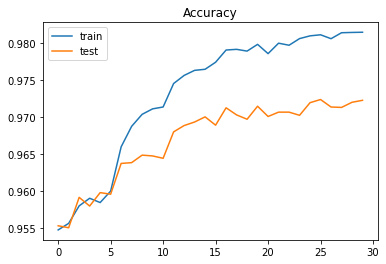

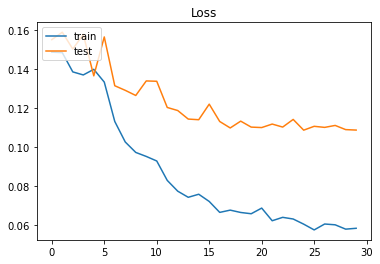

In [39]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.legend(['train','test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.legend(['train','test'], loc='upper left')
plt.show()

### Evaluating Model

In [ ]:
model.evaluate_generator(
    generator=validation_generator,
    steps=valid_num//batch_size
)

### Saving Model

In [53]:
saved_model_path = "saved_models/1"
model.save(saved_model_path)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: saved_models/1\assets


In [56]:
from zipfile import ZipFile 
import os 

def get_all_file_paths(directory): 
  
    # initializing empty file paths list 
    file_paths = [] 
  
    # crawling through directory and subdirectories 
    for root, directories, files in os.walk(directory): 
        for filename in files: 
            # join the two strings in order to form the full filepath. 
            filepath = os.path.join(root, filename) 
            file_paths.append(filepath) 
  
    # returning all file paths 
    return file_paths         

In [57]:
# path to folder which needs to be zipped 
directory = 'saved_models/'

# calling function to get all file paths in the directory 
file_paths = get_all_file_paths(directory) 

# printing the list of all files to be zipped 
print('Following files will be zipped:') 
for file_name in file_paths: 
    print(file_name) 

# writing files to a zipfile 
with ZipFile('saved_models.zip','w') as zip: 
    # writing each file one by one 
    for file in file_paths: 
        zip.write(file) 

print('All files zipped successfully!')    

Following files will be zipped:
saved_models/1\saved_model.pb
saved_models/1\variables\variables.data-00000-of-00001
saved_models/1\variables\variables.index
All files zipped successfully!


### Prediction on Unseen Data

In [58]:
test_generator.reset()
pred=model.predict_generator(
    test_generator,
    steps=test_generator.n//test_generator.batch_size,
    verbose=1
)

Instructions for updating:
Please use Model.predict, which supports generators.
33/33 [==============================] - 1s 18ms/step


In [59]:
predicted_class_indices=np.argmax(pred,axis=1)
predicted_class_indices

array([ 2,  2,  2,  2,  0,  0,  0,  8,  8,  8, 20, 20, 20, 20, 20, 22, 22,
       32, 30, 29, 28, 29, 29, 37, 37, 37, 37, 35, 35, 35, 35, 35, 35],
      dtype=int64)

In [60]:
class_dict = {v:k for k,v in class_dict.items()}
predictions = [class_dict[k] for k in predicted_class_indices]

In [61]:
my_submission = pd.DataFrame({'ImageId': range(1, len(predictions)+1), 'Label': predictions})
my_submission.head()

,ImageId,Label
0,1,Apple___Cedar_apple_rust
1,2,Apple___Cedar_apple_rust
2,3,Apple___Cedar_apple_rust
3,4,Apple___Cedar_apple_rust
4,5,Apple___Apple_scab
